In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
# Cargar dataset

ruta = r"C:\Users\MERBI10\Downloads\Tareas\Proyecto\Proyecto-EDA\data\raw\Base.xlsx"
df = pd.read_excel(ruta)

# Limpieza de valores monetarios
df['Valores'] = df['Valores'].replace('[Q,]', '', regex=True).astype(float)
target_col = 'Valores'

In [3]:
# Preparación de datos

X = df.drop(columns=[target_col])
y = df[target_col]

num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object', 'category']).columns

In [4]:
# Procesador

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, num_features),
    ('cat', categorical_pipeline, cat_features)
])

In [5]:
# División secuencial (80% entrenamiento / 20% validación)

split_index = int(len(X) * 0.8)
X_train, X_val = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_val = y.iloc[:split_index], y.iloc[split_index:]

print(f"Entrenamiento: {X_train.shape}, Validación: {X_val.shape}")

Entrenamiento: (19614, 6), Validación: (4904, 6)


In [6]:
# Definir modelos y grillas de hiperparámetros

modelos = {
    "LinearRegression": {
        "model": LinearRegression(),
        "params": {}
    },
    "Ridge": {
        "model": Ridge(),
        "params": {"model__alpha": [0.1, 1, 10]}
    },
    "Lasso": {
        "model": Lasso(),
        "params": {"model__alpha": [0.01, 0.1, 1]}
    },
    "RandomForest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {"model__n_estimators": [100, 200, 300],
                   "model__max_depth": [5, 10, None]}
    },
    "GradientBoosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {"model__n_estimators": [100, 200, 300],
                   "model__learning_rate": [0.05, 0.1, 0.2]}
    }
}

In [8]:
# Entrenamiento y evaluación de cada modelo

resultados = []
tscv = TimeSeriesSplit(n_splits=3)

for nombre, config in modelos.items():
    print(f"\n Entrenando modelo: {nombre}")
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', config["model"])
    ])
    
    grid = GridSearchCV(
        pipeline,
        param_grid=config["params"],
        scoring='neg_root_mean_squared_error',
        cv=tscv,
        n_jobs=-1
    )
    
    grid.fit(X_train, y_train)
    
    best_rmse = -grid.best_score_
    val_pred = grid.predict(X_val)
    rmse_val = sqrt(mean_squared_error(y_val, val_pred))
    
    resultados.append({
        "modelo": nombre,
        "mejores_parametros": grid.best_params_,
        "RMSE_CV": best_rmse,
        "RMSE_validacion": rmse_val
    })
    
    print(f"Mejor RMSE (CV): {best_rmse:.4f} | RMSE Validación: {rmse_val:.4f}")


 Entrenando modelo: LinearRegression
Mejor RMSE (CV): 603.6333 | RMSE Validación: 553.3714

 Entrenando modelo: Ridge
Mejor RMSE (CV): 599.9362 | RMSE Validación: 548.8696

 Entrenando modelo: Lasso
Mejor RMSE (CV): 598.8732 | RMSE Validación: 568.7385

 Entrenando modelo: RandomForest
Mejor RMSE (CV): 402.8550 | RMSE Validación: 383.4400

 Entrenando modelo: GradientBoosting
Mejor RMSE (CV): 402.6863 | RMSE Validación: 362.9880


In [9]:
# Comparar resultados

resultados_df = pd.DataFrame(resultados)
resultados_df = resultados_df.sort_values(by="RMSE_validacion", ascending=True)
print("\n Resultados finales:")
print(resultados_df)


 Resultados finales:
             modelo                                 mejores_parametros  \
4  GradientBoosting  {'model__learning_rate': 0.2, 'model__n_estima...   
3      RandomForest  {'model__max_depth': 10, 'model__n_estimators'...   
1             Ridge                               {'model__alpha': 10}   
0  LinearRegression                                                 {}   
2             Lasso                                {'model__alpha': 1}   

      RMSE_CV  RMSE_validacion  
4  402.686313       362.987958  
3  402.855016       383.440019  
1  599.936171       548.869636  
0  603.633316       553.371361  
2  598.873186       568.738517  


In [10]:
# Mejor modelo

ganador = resultados_df.iloc[0]
print("\nMejor modelo:", ganador["modelo"])
print("RMSE validación:", ganador["RMSE_validacion"])


Mejor modelo: GradientBoosting
RMSE validación: 362.98795844871773


In [11]:
# Entrenamiento mejor modelo

modelo_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', modelos[ganador["modelo"]]["model"])
])

modelo_final.fit(X, y)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [12]:
# se guarda pipeline + modelo ganador

output_path = os.path.join(os.getcwd(), "final_model_pipeline.pkl")
joblib.dump(modelo_final, output_path)
print(f"\n Pipeline final guardado en: {output_path}")


 Pipeline final guardado en: c:\Users\MERBI10\Downloads\Tareas\Proyecto\Proyecto-EDA\notebooks\final_model_pipeline.pkl


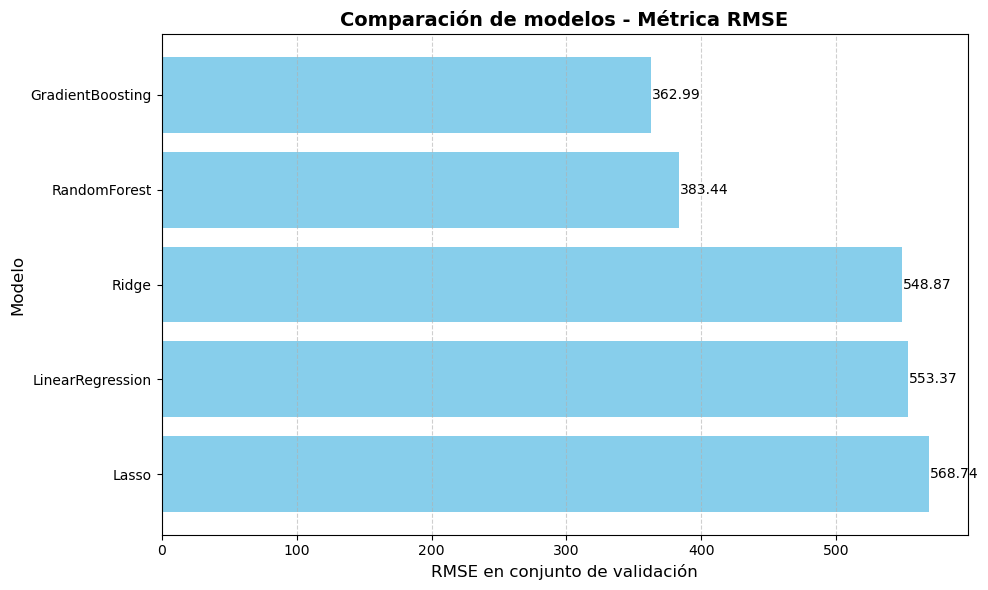

In [13]:
# Visualización comparativa de modelos (RMSE)

import matplotlib.pyplot as plt

resultados_plot = resultados_df.sort_values(by="RMSE_validacion", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(resultados_plot["modelo"], resultados_plot["RMSE_validacion"], color='skyblue')
plt.xlabel("RMSE en conjunto de validación", fontsize=12)
plt.ylabel("Modelo", fontsize=12)
plt.title("Comparación de modelos - Métrica RMSE", fontsize=14, fontweight="bold")

for index, value in enumerate(resultados_plot["RMSE_validacion"]):
    plt.text(value + 0.5, index, f"{value:.2f}", va='center', fontsize=10)

plt.gca().invert_yaxis() 
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Conclusión

En esta fase se desarrolló el proceso completo de entrenamiento, optimización y selección de modelos, utilizando cinco algoritmos distintos y al menos tres configuraciones por cada uno.  
La métrica utilizada fue RMSE, y se seleccionó el modelo con menor error en validación.

El modelo ganador fue  GradientBoosting con un RMSE validación: 362.987, el cual se integró con el pipeline de preprocesamiento para generar el archivo final:

In [17]:
# Generar dataset de testing para la fase de inferencia

import pandas as pd
from pathlib import Path

# Cargar dataset base (el mismo usado en entrenamiento)
ruta_base = Path(r"C:\Users\MERBI10\Downloads\Tareas\Proyecto\Proyecto-EDA\data\raw\Base.xlsx")
df_base = pd.read_excel(ruta_base)

# Limpieza de columna 'Valores'
df_base['Valores'] = df_base['Valores'].replace('[Q,]', '', regex=True).astype(float)

# División secuencial (80% entrenamiento, 20% testing)
split_index = int(len(df_base) * 0.8)
df_test_inference = df_base.iloc[split_index:].copy()

# Eliminar variable objetivo para simular datos "no vistos"
if 'Valores' in df_test_inference.columns:
    df_test_inference = df_test_inference.drop(columns=['Valores'])

# Guardar dataset de testing
ruta_test = Path(r"C:\Users\MERBI10\Downloads\Tareas\Proyecto\Proyecto-EDA\data\raw\Base_Test.xlsx")
df_test_inference.to_excel(ruta_test, index=False)

print(f"Dataset de testing creado en: {ruta_test}")
print(df_test_inference.head())

Dataset de testing creado en: C:\Users\MERBI10\Downloads\Tareas\Proyecto\Proyecto-EDA\data\raw\Base_Test.xlsx
        Año      Sucursal  Mes  Semana     Producto  Unidades
19614  2025  Sucursal 186    5      18   PRODUCTO 9         1
19615  2025  Sucursal 186    5      18  PRODUCTO 10         2
19616  2025  Sucursal 186    6      23   PRODUCTO 2         2
19617  2025  Sucursal 186    6      23   PRODUCTO 4         1
19618  2025  Sucursal 186    6      23   PRODUCTO 6         3
